/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


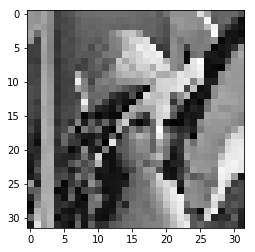

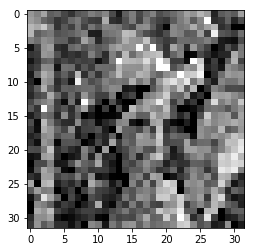

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.transform import rescale, resize
import imageio
from sklearn.mixture import GaussianMixture

def read_image(name):
    image = imageio.imread(name)
    image = resize(image,(32,32))
    image = 255 * image
    image = image.astype(np.uint8)
    data = image.ravel()
    return image, data

def show_image(image):
    image = np.array([image])
    image = np.reshape(image, (32,32))
    image = resize(image,(32,32))
    plt.imshow(image,cmap=cm.gray)
    plt.show()

def add_noise(data, sigma2):
    mean = 0
    gauss = np.random.normal(mean, sigma2, len(data))
    data = data + gauss
    data[data > 255] = 255
    data[data < 0] = 0
    return data

def compute_gmm(image, pixel_values):
    gmm = GaussianMixture(n_components = 256)
    gmm = gmm.fit(X=np.expand_dims(image.flatten(),1))
    gmm_x = np.array(pixel_values).reshape(-1,1)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    plt.plot(gmm_x, gmm_y)
    plt.show

def compute_prob_x(image):
    histo = np.histogram(image.flatten(), range=(0, 255), bins = 256)
    prob_x = histo[0]/np.sum(histo[0])
    return prob_x

def compute_dist_bet_pix(data):
    dist_bet_pix_vec = []
    for k in np.arange(1,len(data)):
        dist_bet_pix = np.abs(int(data[k-1])-int(data[k]))
        dist_bet_pix_vec.append(dist_bet_pix)
    dist_bet_pix_vec = np.array(dist_bet_pix_vec)
    av_dist_pix = sum(dist_bet_pix_vec)/len(dist_bet_pix_vec)
    return av_dist_pix

def compute_gamma(data, var, prob_x):
    init_pi_k = prob_x
    norm_xn = []
    gamma_denom_mat = np.zeros((len(prob_x),len(prob_x)))
    gamma_mat = np.zeros((len(prob_x), len(data)))
    for n in np.arange(len(data)):
        x_n_dist = np.random.normal(data[n], var, 1000)
        his_x = np.histogram(x_n_dist, range=(0, 255), bins = 256)
        his_x[0][his_x[0] < 1] = 1
        prob_xn = his_x[0]/np.sum(his_x[0])
        gamma_nom = init_pi_k[data[n]]*prob_xn
        for k in np.arange(256):
            x_n_cond_k = np.random.normal(k, var, 1000)
            his_x2 = np.histogram(x_n_cond_k, range=(0, 255), bins = 256)
            his_x2[0][his_x[0] < 1] = 1
            prob_xn_cond = his_x[0]/np.sum(his_x[0])
            gamma_denom = init_pi_k[k]*prob_xn_cond
            gamma_denom_mat[k,:] = gamma_denom
        gamma_n = gamma_nom/gamma_denom_mat.sum(axis=0)
        gamma_mat[:,n] = gamma_n
        print(format(n), end="\r")
    #return norm_xn.T

#def compute_gamma_denominator(data, var, prob_x):
#        for i in data:
#            for k in init_mu_k:
                
    
def compute_something(var, prob_x_ij):
    Z = np.eye(len(prob_x_ij))
    pixel_values = np.arange(1,257).reshape(1,len(prob_x_ij))
    init_mu_k = pixel_values
    init_sigma2_k = np.ones((1,len(prob_x_ij)))*var
    init_pi_k = prob_x_ij.reshape(1, len(prob_x_ij))

def denoised_image(chi_matrix, p_x_x_mat):
    I = np.zeros((1,chi_matrix.shape[1]))
    I[:,0] = 100
    for t in np.arange(chi_matrix.shape[1]-1, 1,-1):
        I[:,t] = np.argmax(chi_matrix[:,t-1]+p_x_x_mat[:,t])
    return I

def MSE(denoised_image, image):
    image = np.array([image])
    image = image.reshape(128,128)
    denoised_image = np.array([denoised_image])
    denoised_image = denoised_image.reshape(128,128)
    mse = ((denoised_image - image)**2).mean(axis=None)
    return mse

if __name__=="__main__":
    name="/Users/johanabrahamsson/Documents/Machine learning and data science/Python/lena_gray.jpg"
    image, data = read_image(name)
    show_image(image)
    sigma2 = 30
    noisy_image = add_noise(data, sigma2)
    show_image(noisy_image)
    prob_x = compute_prob_x(image)
    var = compute_dist_bet_pix(data)
    #compute_gmm(image, pixel_values)
    compute_gamma(data, var, prob_x)
    #compute_something(var, prob_x_ij)
    
    
    """"
    prob_x_ij, pixel_values = create_histogram(image)
    prob_y_ij, pixel_values = create_histogram(noisy_image)
    p_y_x_mat = create_p_y_x(noisy_image, sigma2)
    var = compute_dist_bet_pix(data)
    p_x_x_mat = create_p_x_x(data, var)
    chi_matrix = create_chi_matrix(prob_x_ij, p_y_x_mat, p_x_x_mat)
    I = denoised_image(chi_matrix, p_x_x_mat)
    show_image(I)
    mse = MSE(I, image)
    print("MSE =", mse)
    """
    


In [ ]:
import numpy as np
from scipy.stats import norm
np.random.seed(0)
X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+10 # Create data cluster 1
X1 = X*np.random.rand(len(X))-10 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above
"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_tot),3))  
print('Dimensionality','=',np.shape(r))
"""Instantiate the random gaussians"""
gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)
"""
Probability for each datapoint x_i to belong to gaussian g 
"""
for c,g in zip(range(3),[gauss_1,gauss_2,gauss_3]):
    r[:,c] = g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                          # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
"""
Normalize the probabilities such that each row of r sums to 1
"""
for i in range(len(r)):
    r[i] = r[i]/np.sum(r,axis=1)[i] 
"""In the last calculation we normalized the probabilites r_ic. So each row i in r gives us the probability for x_i 
to belong to one gaussian (one column per gaussian). Since we want to know the probability that x_i belongs 
to gaussian g, we have to do smth. like a simple calculation of percentage where we want to know how likely it is in % that
x_i belongs to gaussian g. To realize this, we must dive the probability of each r_ic by the total probability r_i (this is done by 
summing up each row in r and divide each value r_ic by sum(np.sum(r,axis=1)[r_i] )). To get this,
look at the above plot and pick an arbitrary datapoint. Pick one gaussian and imagine the probability that this datapoint
belongs to this gaussian. This value will normally be small since the point is relatively far away right? So what is
the percentage that this point belongs to the chosen gaussian? --> Correct, the probability that this datapoint belongs to this 
gaussian divided by the sum of the probabilites for this datapoint for all three gaussians."""
    
print(r)
print(np.sum(r,axis=1)) # As we can see, as result each row sums up to one, just as we want it.



In [ ]:
for x in range(10):
    print("Progress {:2.1%}".format(x / 10), end="\r")